In [1]:
from functools import lru_cache
from collections import defaultdict

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch, Rectangle
import seaborn as sns
from IPython.display import IFrame
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
import networkx as nx
from pyvis.network import Network
from rdkit.Chem import DataStructs
import MDAnalysis as mda
import prolif as plf
from prolif.plotting.network import LigNetwork

## 1. MD trajectory of a GPCR in complex with a ligand
---

The trajectory of 5-HT1B receptor in complex with ergotamine was downloaded from [GPCRmd, id 90](https://submission.gpcrmd.org/dynadb/dynamics/id/90/):
- [Topology](https://submission.gpcrmd.org/dynadb/files/Dynamics/10872_dyn_90.psf)
- [Trajectory](https://submission.gpcrmd.org/dynadb/files/Dynamics/10869_trj_90.xtc)

There are 1.5 µs of total simulation time (3 replicates), with .2 ns between each frame, but we'll only analyze one replicate here (500ns).

The trajectory is already centered in the box so no need to postprocess it.

In [2]:
# load trajectory with MDAnalysis
u = mda.Universe(
    "/home/cedric/data/Fingerprint/10872_dyn_90.psf",
    "/home/cedric/data/Fingerprint/10869_trj_90.xtc"
)
elements = [mda.topology.guessers.guess_atom_element(n) for n in u.atoms.names]
u.add_TopologyAttr("elements", elements)
# create selections for the ligand and protein
lig = u.atoms.select_atoms("resname ERM")
prot = u.atoms.select_atoms("protein")
# use default interactions
fp = plf.Fingerprint()

In [3]:
# run on a slice of frames from begining to end with a step of 5
# so that there's 1ns between each analyzed frames
fp.run(u.trajectory[::5], lig, prot)
# convert the results to a pandas DataFrame
df = fp.to_dataframe()
df.to_pickle("pickles/ifp_df.pkl")
# show only the 5 first frames
df.head(5)

ligand             ERM1                                                  \
protein           TYR38       ILE39       TYR40      SER106      TYR109   
interaction Hydrophobic Hydrophobic Hydrophobic Hydrophobic Hydrophobic   
Frame                                                                     
0                 False       False       False       False        True   
5                 False       False       False       False        True   
10                False       False       False       False        True   
15                False       False       False       False        True   
20                False       False       False       False        True   

ligand                                                               ...  \
protein          THR110      TRP125      LEU126      ASP129          ...   
interaction Hydrophobic Hydrophobic Hydrophobic Hydrophobic HBDonor  ...   
Frame                                                                ...   
0                 False        True        True        True    True  ...   
5                 False        True        True        True    True  ...   
10                False        True        True        True    True  ...   
15                False        True       False        True    True  ...   
20                False        True        True        True    True  ...   

ligand                                                                 \
protein          PHE346                 LEU348      PHE351              
interaction Hydrophobic PiStacking Hydrophobic Hydrophobic PiStacking   
Frame                                                                   
0                 False      False       False        True      False   
5                 False      False       False        True      False   
10                False      False       False        True      False   
15                False      False       False        True      False   
20                False      False       False        True      False   

ligand                                                                  
protein          ASP352      THR355                 TRP356      TYR359  
interaction Hydrophobic Hydrophobic HBAcceptor Hydrophobic Hydrophobic  
Frame                                                                   
0                  True        True      False       False        True  
5                  True        True      False       False        True  
10                 True        True      False       False        True  
15                 True        True      False       False        True  
20                 True        True      False       False        True  

[5 rows x 50 columns]

In [4]:
# rerun with atom indices
fp.run(u.trajectory[::5], lig, prot, return_atoms=True)
# convert the results to a pandas DataFrame
df = fp.to_dataframe()
df.to_pickle("pickles/ifp_df_atoms.pkl")

### 1.a) Data analysis with pandas

In [5]:
df = (pd.read_pickle("pickles/ifp_df.pkl")
        .astype(np.uint8))

In [6]:
# ignore an interaction
(df.drop("Hydrophobic", level="interaction", axis=1)
   .head(5))

ligand         ERM1                                                       \
protein      ASP129           THR134     VAL201  SER212  THR213   PHE330   
interaction HBDonor Cationic HBDonor HBAcceptor HBDonor HBDonor CationPi   
Frame                                                                      
0                 1        1       0          1       1       0        0   
5                 1        1       0          1       0       0        0   
10                1        1       0          1       0       0        0   
15                1        1       0          1       0       0        0   
20                1        1       0          1       0       0        0   

ligand                                                                         
protein                    PHE331     TRP345     PHE346     PHE351     THR355  
interaction PiStacking PiStacking HBAcceptor PiStacking PiStacking HBAcceptor  
Frame                                                                          
0                    0          1          0          0          0          0  
5                    0          1          0          0          0          0  
10                   1          1          0          0          0          0  
15                   0          0          0          0          0          0  
20                   1          1          0          0          0          0

In [7]:
# share, by residue, of pi-stacking interactions
g = (df.xs("PiStacking", level="interaction", axis=1)
       .sum())
(100 * g / g.sum()).sort_values(ascending=False)

ligand  protein
ERM1    PHE331     48.368794
        PHE330     28.652482
        PHE351     22.269504
        PHE346      0.709220
dtype: float64

F331 makes half of the PiStacking interactions

In [8]:
# share, by interaction type, of SER212 interactions
g = (df.xs("SER212", level="protein", axis=1)
       .sum())
(100 * g / g.sum()).sort_values(ascending=False)

ligand  interaction
ERM1    Hydrophobic    68.567455
        HBDonor        31.432545
dtype: float64

1/3 of S212 interactions are as an H-bond donor

In [9]:
# occurence percentage of each interaction along the simulation
(df.groupby(level="interaction", axis=1)
   .sum()
   .astype(bool)
   .mean()
   .sort_values(ascending=False) * 100)

interaction
Hydrophobic    100.0
HBDonor        100.0
Cationic       100.0
HBAcceptor      91.8
PiStacking      85.0
CationPi         1.6
dtype: float64

There are hydrophobic, H-bond donor, and cationic interactions in all frames

In [10]:
# share of each interaction averaged on all frames
g = (df.groupby(level="interaction", axis=1)
       .sum()
       .mean())
(100 * g / g.sum()).sort_values(ascending=False)

interaction
Hydrophobic    80.808402
HBDonor         5.792489
PiStacking      5.609484
Cationic        3.978358
HBAcceptor      3.747613
CationPi        0.063654
dtype: float64

On average, in each frame 80% of interactions are hydrophobic, 6% are H-bond donor, 6% pi-stacking...etc.

In [11]:
# 10 residues most frequently interacting with the ligand
(df.groupby(level=["ligand", "protein"], axis=1)
   .sum()
   .astype(bool)
   .mean()
   .sort_values(ascending=False)
   .head(10))

ligand  protein
ERM1    ASP129     1.000
        ILE130     1.000
        PHE330     1.000
        VAL201     0.998
        PHE331     0.998
        SER212     0.988
        TRP327     0.982
        VAL200     0.982
        CYS133     0.976
        PHE351     0.974
dtype: float64

### 1.b) Similarity between binding modes

In [12]:
# compute tanimoto similarity matrix
bvs = plf.to_bitvectors(df)
mat = []
for bv in bvs:
    mat.append(DataStructs.BulkTanimotoSimilarity(bv, bvs))
mat = pd.DataFrame(mat, index=df.index, columns=df.index)

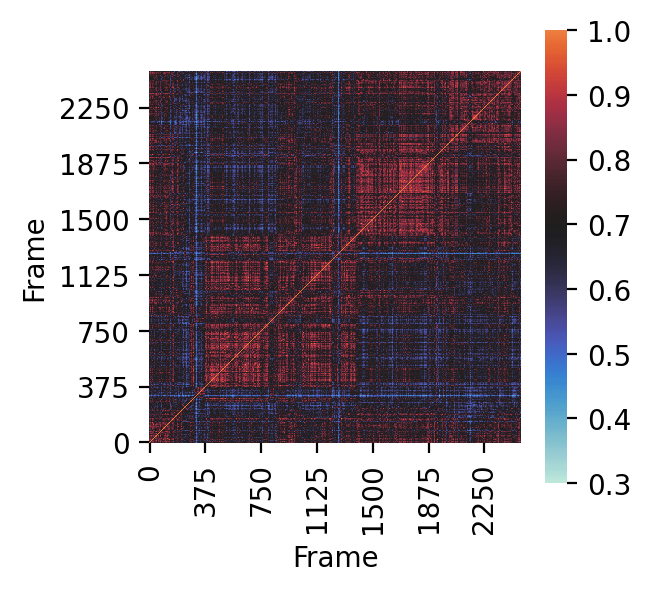

In [13]:
# display heatmap
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
sns.heatmap(
    mat, ax=ax, square=True,
    cmap="icefire",
    vmin=.3, vmax=1, center=.7,
    xticklabels=75, yticklabels=75,
)

ax.invert_yaxis()
fig.patch.set_facecolor('white')

In [14]:
fig.savefig("../Figures/similarity_matrix.png", bbox_inches="tight", dpi=300)

We can also sort one axis of the matrix to make the clusters more visible

In [15]:
# KMeans clustering

def bv_to_np(bv):
    """convert rdkit bitvector to numpy array"""
    arr = np.zeros((0,))
    DataStructs.ConvertToNumpyArray(bv, arr)
    return arr

fps = np.array([bv_to_np(bv) for bv in bvs])
kmean = KMeans(n_clusters=2, random_state=0)
clusters = kmean.fit_predict(fps)

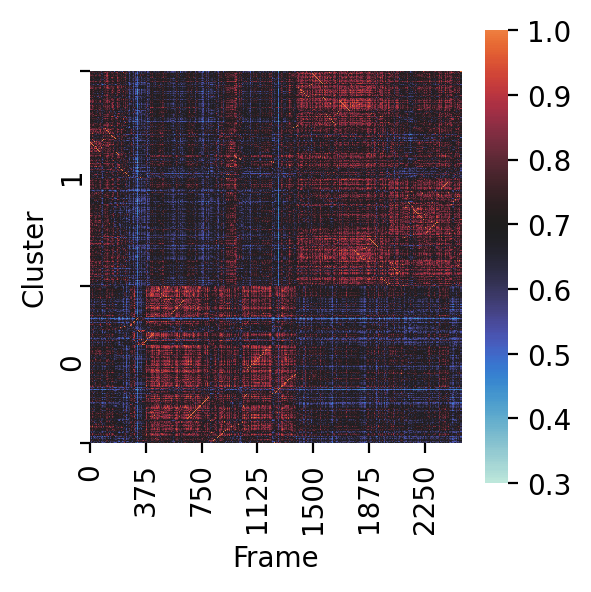

In [16]:
# display heatmap sorted by cluster
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
sns.heatmap(
    # matrix sorted by cluster
    (mat
     .assign(Cluster=lambda x: clusters)
     .set_index("Cluster")
     .sort_index()
    ),
    ax=ax, square=True,
    cmap="icefire",
    vmin=.3, vmax=1, center=.7,
    xticklabels=75,
    yticklabels=0,
)

# show tick on heatmap's y-axis when new cluster
sc = np.sort(clusters)
# find index where a new cluster is assigned
s = np.argwhere(sc[1:] - sc[:-1]) + 1
s = s.flatten().tolist()
s = [0] + s + [sc.size]
# set on y axis
ax.set_yticks(s)
ax.invert_yaxis()
ax.yaxis.labelpad = 8
for c, (i1, i2) in enumerate(zip(s[:-1], s[1:])):
    ax.text(-42, (i1 + i2) / 2, c, rotation=90,)
fig.patch.set_facecolor('white')

In [17]:
fig.savefig("../Figures/similarity_matrix_clustered.png", bbox_inches="tight", dpi=300)

In [18]:
# get closest frame to each cluster center
closest, dists = vq(kmean.cluster_centers_, fps)
data = df.iloc[closest].copy()
# only show columns with differences between clusters
data.loc[:, data.nunique() > 1]

ligand             ERM1                                              \
protein          TRP125      THR203      THR209  SER212      SER334   
interaction Hydrophobic Hydrophobic Hydrophobic HBDonor Hydrophobic   
Frame                                                                 
420                   1           0           0       1           0   
1680                  0           1           1       0           1   

ligand                              
protein         PHE351      ASP352  
interaction PiStacking Hydrophobic  
Frame                               
420                  1           0  
1680                 0           1

### 1.c) Display LigPlot

We'll aggregate the IFP and only display interactions that occur in at least 30% of frames

In [19]:
df = pd.read_pickle("pickles/ifp_df_atoms.pkl")
lmol = plf.Molecule.from_mda(lig)

def prep_aggregate(df, threshold=.3):
    """aggregate and keep occuring over a defined threshold"""
    data = (pd.get_dummies(df.applymap(lambda x: x[0])
                             .astype(object),
                           prefix_sep=", ")
              .rename(columns=lambda x:
                      x.translate({ord(c): None for c in "()'"}))
              .mean()
           )
    index = [i.split(", ") for i in data.index]
    index = [[j for j in i[:-1]+[int(float(i[-1]))]] for i in index]
    data.index = pd.MultiIndex.from_tuples(index, names=["ligand", "protein", "interaction", "atom"])
    data = data.to_frame()
    data.rename(columns={data.columns[-1]: "weight"}, inplace=True)
    # merge different ligand atoms before applying the threshold
    data = data.join(data.groupby(level=["ligand", "protein", "interaction"]).sum(), rsuffix="_total")
    # threshold and keep most occuring atom
    data = (data.loc[data["weight_total"] >= threshold]
                .drop(columns="weight_total")
                .sort_values("weight", ascending=False)
                .groupby(level=["ligand", "protein", "interaction"])
                .head(1)
                .sort_index()
           )
    return data

def prep_frame(df, frame):
    """Return LigNetwork data for a single frame"""
    data = (df
     .loc[df.index == 420]
     .T
     .applymap(lambda x: x[0])
     .dropna()
     .astype(int)
     .reset_index()
    )
    data.rename(columns={data.columns[-1]: "atom"}, inplace=True)
    data["weight"] = 1
    data.set_index(["ligand", "protein", "interaction", "atom"], inplace=True)
    return data

In [20]:
net = LigNetwork(prep_aggregate(df, .3), lmol, rotation=110)
net.display()

## 2. Protein-protein interactions (PPI) within the GPCR
---

In [21]:
# run with the same parameters as before
fp.run(u.trajectory[::5], prot, prot)
# convert the results to a pandas DataFrame
df = fp.to_dataframe()
df.to_pickle("pickles/ppi_gpcr.pkl")
# show only the 5 first frames
df.head(5)

ligand            TYR38                                                \
protein           TYR38                  ILE39       TYR40              
interaction Hydrophobic PiStacking Hydrophobic Hydrophobic HBAcceptor   
Frame                                                                   
0                  True       True        True        True      False   
5                  True       True        True        True      False   
10                 True       True        True       False      False   
15                 True       True        True        True      False   
20                 True       True        True        True      False   

ligand                                                                ...  \
protein                      GLN41                  ASP42             ...   
interaction PiStacking Hydrophobic HBAcceptor Hydrophobic HBAcceptor  ...   
Frame                                                                 ...   
0                False       False      False       False      False  ...   
5                False       False      False       False      False  ...   
10               False       False      False       False      False  ...   
15               False       False      False       False      False  ...   
20               False       False      False       False      False  ...   

ligand           LYS387                                                 \
protein          PHE380      HSD381                 LYS382      ILE384   
interaction Hydrophobic Hydrophobic HBAcceptor Hydrophobic Hydrophobic   
Frame                                                                    
0                 False       False      False       False       False   
5                 False       False      False       False       False   
10                False       False      False       False       False   
15                False       False      False       False       False   
20                False       False      False       False       False   

ligand                                                           
protein          ARG385              PHE386              LYS387  
interaction Hydrophobic HBDonor Hydrophobic HBDonor Hydrophobic  
Frame                                                            
0                 False   False        True   False        True  
5                 False   False        True   False        True  
10                False   False        True   False        True  
15                False   False        True   False        True  
20                False   False        True   False        True  

[5 rows x 6239 columns]

In [22]:
# read annotated sequence from GPCRdb
ht1b = pd.read_excel("../Data/5ht1b_gpcrdb.xlsx",
                     header=None, skipfooter=2)
ht1b.values[0, 0] = "Label"
ht1b.values[1, 0] = "Helix number"
ht1b.values[-1, 0] = "Sequence"
ht1b.set_index(0, inplace=True)
ht1b.iloc[0].fillna(method="ffill", inplace=True)
ht1b = ht1b.T

@lru_cache(maxsize=None)
def get_ht1b_info(number):
    return ht1b.iloc[number - 1]

ht1b

,Label,Helix number,Sequence-based (BW),Structure-based (GPCRdb),Sequence
1,N-term,NaN,NaN,NaN,M
2,N-term,NaN,NaN,NaN,E
3,N-term,NaN,NaN,NaN,E
4,N-term,NaN,NaN,NaN,P
5,N-term,NaN,NaN,NaN,G
...,...,...,...,...,...
386,C-term,NaN,NaN,NaN,F
387,C-term,NaN,NaN,NaN,K
388,C-term,NaN,NaN,NaN,C
389,C-term,NaN,NaN,NaN,T


In [23]:
# drop some of the interactions
df = pd.read_pickle("pickles/ppi_gpcr.pkl")
# remove hydrophobic
df.drop("Hydrophobic", level="interaction", axis=1, inplace=True)
mask = [True for _ in df.columns]
for i, (l, p, interaction) in enumerate(df.columns):
    if mask[i] == False:
        continue
    lr = plf.ResidueId.from_string(l)
    pr = plf.ResidueId.from_string(p)
    li = get_ht1b_info(lr.number)["Label"]
    pi = get_ht1b_info(pr.number)["Label"]
    same_domain = li == pi
    same_helix = same_domain and (li.startswith("TM") or li.startswith("H"))
    if (
        (abs(pr.number - lr.number) <= 1) # filter out covalent
        or same_helix # filter out interactions within same helix
    ):
        mask[i] = False
    # remove symetrical interaction
    try:
        col = df.columns.get_loc((p, l, interaction))
    except KeyError:
        pass
    else:
        mask[col] = False
    
df = df[df.columns[mask]]
df.shape

(500, 799)

In [24]:
# group different interactions types together
data = (df
        .groupby(level=["ligand", "protein"], axis=1, sort=False)
        .sum()
        .astype(bool)
        .mean())
# restrict to interactions occuring in more than 5% of frames
data = data.loc[data > .05]

colors = {
    "TM1": "#8dd3c7",
    "TM2": "#ffffb3",
    "TM3": "#bebada",
    "TM4": "#fb8072",
    "TM5": "#80b1d3",
    "TM6": "#fdb462",
    "TM7": "#b3de69",
    "H8": "#fccde5",
}

G = nx.Graph()
# add nodes
residues = sorted(np.unique([list(i) for i in data.index.values]),
                  key=lambda r: plf.ResidueId.from_string(r))

for res in residues:
    resid = plf.ResidueId.from_string(res)
    info = get_ht1b_info(resid.number)
    name = f'{info["Sequence"]}{resid.number}'
    domain = info["Label"]
    color = colors.get(domain, "#cccccc")
    hnum = info["Helix number"]
    if isinstance(hnum, str):
        note = (f'{hnum}.{info["Sequence-based (BW)"]}'
                f'x{info["Structure-based (GPCRdb)"]}')
        title = note
    else:
        title = domain
    title = f"{name}<br/>{title}"
    G.add_node(res, label=name, title=title, borderWidth=1,
               shape="circle", color=color)

# add interactions
for resids, value in data.items():
    label = "{} - {}<br/>{}".format(*resids, "<br/>".join([f"{k}: {v}"
                                   for k, v in (df.xs(resids,
                                                      level=["ligand", "protein"],
                                                      axis=1)
                                                  .sum()
                                                  .to_dict()
                                                  .items())]))
    width = (1 + value)**5
    G.add_edge(*resids, title=label, color="#a9a9a9",
               weight=value, width=width, freq=value)

# highlight nodes
highlight = defaultdict(list)
for r1, r2, d in G.edges(data=True):
    highlight[r1].append(d["freq"])
    highlight[r2].append(d["freq"])
for res, freqs in highlight.items():
    # set fontsize based on max frequency of interaction
    s = max(freqs)
    G.nodes[res]["font"] = {"face": "Monospace",
                            "size": (1 + s)**7.5}

# convert to pyvis network
net = Network(width=1000, height=1000,  notebook=True, heading="")
net.from_nx(G)

# sort nodes by fontsize so that bigger nodes are drawn on top
net.nodes = sorted(net.nodes, key=lambda x: x["font"]["size"])

# force circular layout
layout = nx.circular_layout(G)
for node in net.nodes:
    node["x"] = layout[node["id"]][0] * 2000
    node["y"] = layout[node["id"]][1] * 2000
net.toggle_physics(False)

net.write_html("ppi_gpcr.html")
IFrame("../Figures/ppi_gpcr.html", width="100%", height=1000)

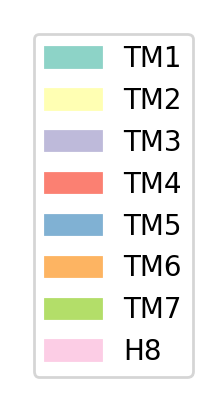

In [26]:
# legend for the corresponding figure in the paper
fig, ax = plt.subplots(figsize=(1, 2), dpi=200)
handles = []
for domain, hexcol in colors.items():
    item = Patch(color=hexcol, label=domain)
    handles.append(item)
leg = plt.legend(handles=handles, ncol=1, loc="upper left")
plt.axis('off')
# fig.patch.set_facecolor('white')
fig.savefig("../Figures/gpcr_ppi_legend.png", bbox_inches="tight", dpi=300)

## 3. Protein-protein interactions between a GPCR and a G protein

Analysis of PPI for the β2 adrenoreceptor (PDB 3SN6) which contains a class A GPCR in complex if a G protein

In [27]:
import itertools
from functools import lru_cache
import json
import re
from html import escape
import warnings

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch, Rectangle
from IPython.display import IFrame, HTML
import networkx as nx
from pyvis.network import Network
import MDAnalysis as mda
from MDAnalysis.topology.tables import vdwradii
import prolif as plf
from rdkit import Chem

warnings.filterwarnings("ignore", "Consider using IPython.display.IFrame instead")

PQR file was prepared by submitting a job to the [PDB2PQR webserver](https://server.poissonboltzmann.org/pdb2pqr) with:
- PDB id 3SN6
- AMBER force-field and naming scheme
- PROPKA to assign protonation states at pH 7.0
- Keeping existing chain IDs
- Dropping water molecules

In [28]:
# use RDKit to read PQR file
mol = Chem.MolFromPDBFile("../Data/3sn6.pqr", removeHs=False)
# convert to MDAnalysis
u = mda.Universe(mol)
gpcr = u.select_atoms("protein and chainID R")
gprotein = u.select_atoms("protein and not chainID R")
gpcr, gprotein

(<AtomGroup with 7175 atoms>, <AtomGroup with 13670 atoms>)

Custom implementation of the van der Waals contact interaction used in the original paper by [Flock et al.](https://doi.org/10.1038/nature22070)

In [29]:
class VdWContact(plf.interactions.Interaction):
    """Interaction based on the van der Waals radii of interacting atoms.
    
    Parameters
    ----------
    tolerance : float
        Tolerance added to the sum of vdW radii of atoms before comparing to
        the interatomic distance. If ``distance <= sum_vdw + tolerance`` the
        atoms are identified as a contact
    """
    def __init__(self, tolerance=.6):
        self.tolerance = tolerance

    def detect(self, ligand, residue):
        lxyz = ligand.GetConformer()
        rxyz = residue.GetConformer()
        for la, ra in itertools.product(ligand.GetAtoms(), residue.GetAtoms()):
            lig_atom = la.GetSymbol().upper()
            res_atom = ra.GetSymbol().upper()
            sum_vdw = vdwradii[lig_atom] + vdwradii[res_atom]
            dist = (lxyz.GetAtomPosition(la.GetIdx())
                        .Distance(rxyz.GetAtomPosition(ra.GetIdx())))
            if dist - sum_vdw <= self.tolerance:
                return True
        return False

In [30]:
# use custom vdw contact class in prolif
# and run on the multiple complexes (GPCR/GPCR, Gprot/Gprot, and Gprot/GPCR)
fp = plf.Fingerprint(["VdWContact"])
fp.run(u.trajectory, gprotein, gpcr)
df_i = fp.to_dataframe()
fp.run(u.trajectory, gprotein, gprotein)
df_gprot = fp.to_dataframe()
fp.run(u.trajectory, gpcr, gpcr)
df_gpcr = fp.to_dataframe()

In [31]:
# read annotated sequences from GPCRdb
adrb2 = pd.read_excel("../Data/adrb2_gpcrdb.xlsx",
                      header=None, skipfooter=2)
adrb2.values[0, 0] = "Label"
adrb2.values[1, 0] = "Helix number"
adrb2.values[-1, 0] = "Sequence"
adrb2.set_index(0, inplace=True)
adrb2.iloc[0].fillna(method="ffill", inplace=True)
adrb2 = adrb2.T

@lru_cache(maxsize=None)
def get_adrb2_info(number):
    # in the PDB input file, endolysin is numbered starting from 1000
    # but we don't need it here
    if number >= 1000:
        return {"Label": "nan"}
    return adrb2.iloc[number - 1]

gnas = pd.read_excel("../Data/gnas_gpcrdb.xlsx",
                      header=None, skipfooter=2)
gnas.values[0, 0] = "Label"
gnas.values[1, 0] = "Helix number"
gnas.values[-1, 0] = "Sequence"
gnas.set_index(0, inplace=True)
gnas.iloc[0].fillna(method="ffill", inplace=True)
gnas = gnas.T

@lru_cache(maxsize=None)
def get_gnas_info(number):
    return gnas.iloc[number - 1]

adrb2

,Label,Helix number,Sequence-based (BW),Structure-based (GPCRdb),Sequence
1,N-term,NaN,NaN,NaN,M
2,N-term,NaN,NaN,NaN,G
3,N-term,NaN,NaN,NaN,Q
4,N-term,NaN,NaN,NaN,P
5,N-term,NaN,NaN,NaN,G
...,...,...,...,...,...
409,C-term,NaN,NaN,NaN,N
410,C-term,NaN,NaN,NaN,D
411,C-term,NaN,NaN,NaN,S
412,C-term,NaN,NaN,NaN,L


In [32]:
# filter out some of the interactions
def filter_interactions(df, contacts, gpcr=False):
    mask = []
    for l, p, interaction in df.columns:
        lr = plf.ResidueId.from_string(l)
        pr = plf.ResidueId.from_string(p)
        get_info = get_adrb2_info if gpcr else get_gnas_info
        same_helix = get_info(lr.number)["Label"] == get_info(pr.number)["Label"]
        if same_helix:
            if gpcr:
                same_helix &= get_info(lr.number)["Label"].startswith("TM")
            else:
                same_helix &= get_info(lr.number)["Label"].startswith("H")
        if (
            (abs(pr.number - lr.number) <= 1) or # filter out covalent
            (same_helix ) or # filter out interactions within same helix
            any(r not in contacts for r in (l, p)) or # filter out residues that don't appear in gpcr-prot interactions
            (gpcr and any(r.number >= 1000 for r in (lr, pr))) # filter out endolysin
           ):
            mask.append(False)
        else:
            mask.append(True)
    return df[df.columns[mask]]

def sort_ifp_columns(df, order=["ligand", "protein", "interaction"]):
    df = df.copy()
    cols = np.array([(
            plf.ResidueId.from_string(i[0]),
            plf.ResidueId.from_string(i[1]),
            i[2])
        for i in df.columns.values],
        dtype=[("ligand", object), ("protein", object), ("interaction", object)])
    df.columns = df.columns[np.argsort(cols, order=order)]
    df = df.reorder_levels(order, axis=1)
    return df

df = df_i.copy()
contacts = np.unique([list(i[:2]) for i in df_i.columns.values])
d = filter_interactions(df_gprot, contacts)
df = pd.concat([df, d], axis=1)
d = filter_interactions(df_gpcr, contacts, gpcr=True)
df = pd.concat([df, d], axis=1)
df = sort_ifp_columns(df)
df = df.droplevel("interaction", axis=1)
df.to_pickle("pickles/ppi.pkl")

In [33]:
df = pd.read_pickle("pickles/ppi.pkl")
contacts = np.array([list(i) for i in df.columns.values])
contacts = np.unique(np.sort(contacts, axis=1), axis=0)
len(contacts)

64

In [34]:
# custom vis.js network interface, because pyvis implementation
# hasn't been updated in a while and doesn't support some of the
# arguments needed to make this figure
class Network:
    _JS_TEMPLATE = """
        var nodes, edges;
        function drawGraph(_id, nodes, edges, options) {
            var container = document.getElementById(_id);
            nodes = new vis.DataSet(nodes);
            edges = new vis.DataSet(edges);
            var data = {nodes: nodes, edges: edges};
            var network = new vis.Network(container, data, options);
            %(post_initialization)s
            return network;
        }
        nodes = %(nodes)s;
        edges = %(edges)s;
        network = drawGraph('%(div_id)s', nodes, edges, %(options)s);
    """
    _HTML_TEMPLATE = """
        <html>
        <head>
        <script type="text/javascript" src="https://unpkg.com/vis-network@9.0.4/dist/vis-network.min.js"></script>
        <link href="https://unpkg.com/vis-network@9.0.4/dist/dist/vis-network.min.css" rel="stylesheet" type="text/css" />
        <style type="text/css">
            body { padding: 0; margin: 0; }
        </style>
        </head>
        <body>
        <div id="mynetwork"></div>
        <div id="networklegend"></div>
        <script type="text/javascript">
            %(js)s
        </script>
        </body>
        </html>
    """
    def __init__(self):
        self.nodes = []
        self.edges = []
        self.post_initialization = ""

    def add_node(self, _id, **kwargs):
        self.nodes.append({"id": _id, **kwargs})

    def add_edge(self, _from, to, **kwargs):
        self.edges.append({"from": _from, "to": to, **kwargs})
    
    def _get_js(self, width="100%", height="500px", div_id="mynetwork",
        fontsize=20):
        """Returns the JavaScript code to draw the network"""
        self.width = width
        self.height = height
        options = {
            "width": width,
            "height": height,
        }
        options.update(self.options)
        js = self._JS_TEMPLATE % dict(div_id=div_id,
                                      nodes=json.dumps(self.nodes),
                                      edges=json.dumps(self.edges),
                                      options=json.dumps(options),
                                      post_initialization=self.post_initialization,
                                     )
        return js
    
    def _get_html(self, **kwargs):
        """Returns the HTML code to draw the network"""
        return self._HTML_TEMPLATE % dict(js=self._get_js(**kwargs))

    def display(self, **kwargs):
        """Prepare and display the network"""
        html = self._get_html(**kwargs)
        iframe = ('<iframe width="{width}" height="{height}" frameborder="0" '
                  'srcdoc="{doc}"></iframe>')
        return HTML(iframe.format(width=self.width, height=self.height,
                                  doc=escape(html)))
    
    def show(self, filename, **kwargs):
        """Save and display the network"""
        html = self._get_html(**kwargs)
        with open(filename, "w") as f:
            f.write(html)
        iframe = ('<iframe width="{width}" height="{height}" frameborder="0" '
                  'src="{filename}"></iframe>')
        return HTML(iframe.format(width=self.width, height="500px" if "%" in self.height else self.height,
                                  filename=filename))

In [35]:
# plot the network

net = Network()
colors = {
    "ICL1": "#f7fcfd",
    "TM3": "#e5f5f9",
    "ICL2": "#ccece6",
    "TM5": "#99d8c9",
    "ICL3": "#66c2a4",
    "TM6": "#41ae76",
    
    "hns1": "#fff7fb",
    "S1": "#ece7f2",
    "S3": "#d0d1e6",
    "H4": "#a6bddb",
    "h4s6": "#74a9cf",
    "H5": "#3690c0",
}
rid_cache = {}
nodes = np.unique(contacts)

for r in nodes:
    rid = plf.ResidueId.from_string(r)
    rid_cache[r] = rid
    label = f"{rid.name}{rid.number}"
    if rid.chain == "R":
        info = get_adrb2_info(rid.number)
        struct = info["Label"]
        hnum = info["Helix number"]
        if isinstance(hnum, str):
            note = (f'{hnum}.{info["Sequence-based (BW)"]}'
                    f'x{info["Structure-based (GPCRdb)"]}')
            title = f"{struct}\n{note}"
            label = f"{note}\n{label}"
        else:
            title = struct
            label = f"{struct}\n{label}"
        color = colors.get(struct, "grey")
        net.add_node(r, label=label, title=title, shape="box",
                     color=color, dtype="gpcr", margin=20)
    else:
        if rid.chain == "A":
            info = get_gnas_info(rid.number)
            struct = info["Label"]
            if isinstance(info["Helix number"], str):
                note = (f'{info["Helix number"]}.{info["Sequence-based ()"]}'
                        f'.{info["Structure-based (GPCRdb)"]}')
                title = f"Gs-α\n{note}"
                label = f"{note}\n{label}"
            else:
                title = "Gαs"
            color = colors.get(struct, "grey")
            net.add_node(r, label=label, title=title, shape="circle",
                         color=color, dtype="gprotein")
        else:
            title = "Gβ1"
            label = f"{title}\n{label}"
            net.add_node(r, label=label, title=title, shape="circle",
                         color="#fec44f", dtype="gprotein")

for r1, r2 in contacts:
    rid1 = rid_cache[r1]
    rid2 = rid_cache[r2]
    label = f"{r1} - {r2}"
    same_chain = rid1.chain == rid2.chain
    width = 3
    length = 100 if same_chain else 300
    dashes = [10] if same_chain else False
    net.add_edge(r1, r2, length=length, title=label, color="#a9a9a9",
                 width=width, selectionWidth=6, dashes=dashes)

for i in range(len(nodes)):
    node = net.nodes[i]
    nid = node["id"]
    n_neighbors = 0
    for edge in net.edges:
        if nid in [edge["from"], edge["to"]]:
            n_neighbors += 1
    node["margin"] = max(5, n_neighbors*3.5)

net.options = {
    "nodes": {
        "font": {
            "size": 36,
        },
    },
    "edges": {
        "smooth": {
            "type": "continuous",
        },
    },
    "physics": {
        "hierarchicalRepulsion": {
            "avoidOverlap": 0.8,
            "springConstant": 0.005,
        },
        "solver": "hierarchicalRepulsion",
        "minVelocity": 3,
    },
    "interaction": {
        "hover": True,
        "multiselect": True,
    },
}
net.post_initialization = """
network.on("stabilizationIterationsDone", function () {
    network.setOptions( { physics: false } );
});
"""
net.show("../Figures/ppi.html", height="100%")

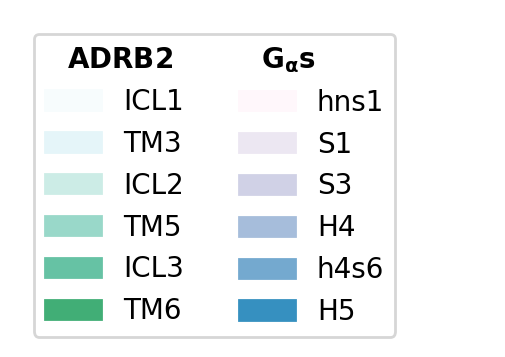

In [36]:
# legend for the corresponding figure in the paper
fig, ax = plt.subplots(figsize=(3, 2), dpi=200)
handles = []
for i, (domain, hexcol) in enumerate(colors.items()):
    if i % 6 == 0:
        label = "$\\bf{ADRB2}$" if i == 0 else "$\\bf{G_{α}s}$"
        item = Rectangle((0, 0), 0, 0, color="w", label=label)
        handles.append(item)
    item = Patch(color=hexcol, label=domain)
    handles.append(item)
leg = plt.legend(handles=handles, ncol=2, loc="upper left")
for vpack in leg._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
plt.axis('off')
fig.patch.set_facecolor('white')
fig.savefig("../Figures/ppi_legend.png", bbox_inches="tight", dpi=300)